In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as mp
%matplotlib inline

In [12]:
def simulate(n_gal, n_star, abs_true, s_true, mu_bar, mu_sig, mu_hat_sig, m_sig_int, m_hat_sig):
    
    # distance moduli
    mu_true = np.sort(npr.randn(n_gal) * mu_sig + mu_bar)
    mu_hat = mu_true[0] + npr.randn(1) * mu_hat_sig
    
    # log periods and apparent magnitudes
    lp_true = np.reshape(1.0 + npr.rand(n_gal * n_star), (n_gal, n_star))
    m_true = np.zeros((n_gal, n_star))
    for i in range(n_gal):
        m_true[i, :] = mu_true[i] + abs_true + s_true * lp_true[i, :]
    m_hat = m_true + npr.randn(n_gal * n_star).reshape(n_gal, n_star) * m_hat_sig
    
    return (mu_true, lp_true, m_true, mu_hat, m_hat)

In [23]:
# setup
n_gal = 2
n_star = 200
n_samples = 50000

abs_bar = -26.0
abs_sig = 4.0
s_bar = -1.0
s_sig = 1.0
mu_bar = 30.0
mu_sig = 5.0

mu_hat_sig = 0.01
m_sig_int = 0.05
m_hat_sig = 0.02

mu_true, lp_true, m_true, mu_hat, m_hat = simulate(n_gal, n_star, abs_bar, s_bar, mu_bar, mu_sig, mu_hat_sig, m_sig_int, m_hat_sig)

0.01992490864463488


(array([ 3.,  7., 19., 55., 71., 86., 84., 47., 18., 10.]),
 array([-0.06121384, -0.04992619, -0.03863854, -0.02735089, -0.01606324,
        -0.00477559,  0.00651206,  0.01779971,  0.02908735,  0.040375  ,
         0.05166265]),
 <a list of 10 Patch objects>)

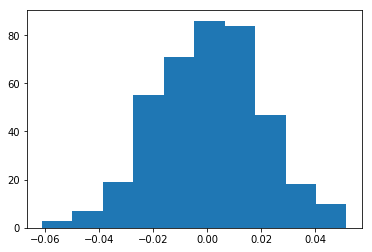

In [24]:
print (m_true - m_hat).flatten().std()
mp.hist((m_true - m_hat).flatten())

In [25]:
def gibbs_sample(n_samples, n_gal, n_star, abs_bar, abs_sig, \
                 s_bar, s_sig, mu_bar, mu_sig, mu_hat_sig, \
                 m_sig_int, m_hat_sig, mu_hat, lp_true, m_hat):
    
    # storage
    abs_samples = np.zeros(n_samples)
    s_samples = np.zeros(n_samples)
    mu_samples = np.zeros((n_gal, n_samples))
    m_samples = np.zeros((n_gal, n_star, n_samples))
    
    # initialize sampler
    abs_samples[0] = abs_bar + npr.randn(1) * abs_sig
    s_samples[0] = s_bar + npr.randn(1) * s_sig
    mu_samples[:, 0] = mu_bar + npr.randn(n_gal) * mu_bar
    for i in range(n_gal):
        m_samples[i, :, 0] = mu_samples[i, 0] + abs_samples[0] + s_samples[0] * lp_true[i, :]
    
    # sample!
    for i in range(1, n_samples):
        
        # sample abs mag
        abs_std = m_sig_int / np.sqrt(n_gal * n_star)
        abs_mean = 0.0
        for j in range(n_gal):
            abs_mean += np.sum(m_samples[j, :, i - 1] - mu_samples[j, i - 1] - s_samples[i - 1] * lp_true[j, :])
        abs_mean /= (n_gal * n_star)
        abs_samples[i] = abs_mean + npr.randn(1) * abs_std
        
        # sample slope
        s_std = m_sig_int / np.sqrt(np.sum(lp_true ** 2))
        s_mean = 0.0
        for j in range(n_gal):
            s_mean += np.sum((m_samples[j, :, i - 1] - mu_samples[j, i - 1] - abs_samples[i]) * lp_true[j, :])
        s_mean /= np.sum(lp_true ** 2)
        s_samples[i] = s_mean + npr.randn(1) * s_std
        
        # sample apparent magnitudes
        for j in range(n_gal):
            m_mean_pl = mu_samples[j, i - 1] + abs_samples[i] + s_samples[i] * lp_true[j, :]
            m_std = np.sqrt(m_sig_int ** 2 * m_hat_sig ** 2 / (m_sig_int ** 2 + m_hat_sig ** 2))
            m_mean = (m_sig_int ** 2 * m_hat[j, :] + m_hat_sig ** 2 * m_mean_pl) / (m_sig_int ** 2 + m_hat_sig ** 2)
            m_samples[j, :, i] = m_mean + npr.randn(n_star) * m_std
            
        # sample distance moduli
        mu_sig_pl = m_sig_int / np.sqrt(n_star)
        mu_mean_pl = np.mean(m_samples[0, :, i] - abs_samples[i] - s_samples[i] * lp_true[0, :])
        mu_var = 1.0 / (1.0 / mu_sig ** 2 + 1.0 / mu_hat_sig ** 2 + 1.0 / mu_sig_pl ** 2)
        mu_mean = (mu_bar / mu_sig ** 2 + mu_hat / mu_hat_sig ** 2 + mu_mean_pl / mu_sig_pl ** 2) * mu_var
        mu_samples[0, i] = mu_mean + npr.randn(1) * np.sqrt(mu_var)
        for j in range(1, n_gal):
            mu_sig_pl = m_sig_int / np.sqrt(n_star)
            mu_mean_pl = np.mean(m_samples[j, :, i] - abs_samples[i] - s_samples[i] * lp_true[j, :])
            mu_var = 1.0 / (1.0 / mu_sig ** 2 + 1.0 / mu_sig_pl ** 2)
            mu_mean = (mu_bar / mu_sig ** 2 + mu_mean_pl / mu_sig_pl ** 2) * mu_var
            mu_samples[j, i] = mu_mean + npr.randn(1) * np.sqrt(mu_var)
        
    return (abs_samples, s_samples, mu_samples, m_samples)

In [26]:
test = gibbs_sample(n_samples, n_gal, n_star, abs_bar, abs_sig, \
                 s_bar, s_sig, mu_bar, mu_sig, mu_hat_sig, \
                 m_sig_int, m_hat_sig, mu_hat, lp_true, m_hat)

-25.98719836855995 0.017203691618151076 -26.0


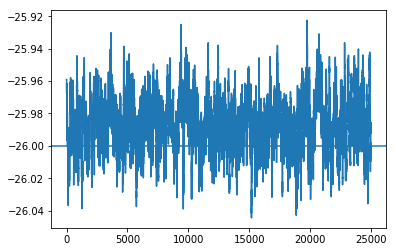

In [27]:
mp.plot(test[0][n_samples/2:])
mp.axhline(abs_bar)
print np.mean(test[0][n_samples/2:]), np.std(test[0][n_samples/2:]), abs_bar

-1.0005822496210512 0.009409062264131384 -1.0


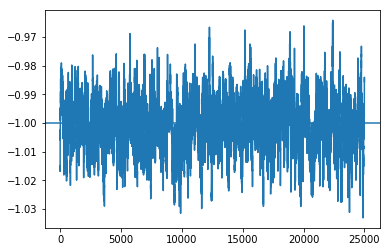

In [28]:
mp.plot(test[1][n_samples/2:])
mp.axhline(s_bar)
print np.mean(test[1][n_samples/2:]), np.std(test[1][n_samples/2:]), s_bar

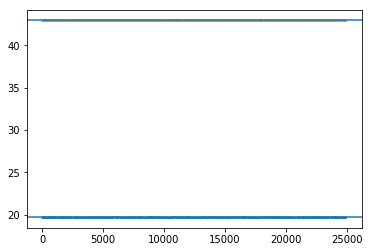

In [29]:
for i in range(n_gal):
    mp.plot(test[2][i][n_samples/2:])
    mp.axhline(mu_true[i])

-7.732274883576124 0.01868403870647573 -7.773902495417269
-8.25626138451437 0.018591752957282142 -8.271024936336326
-7.70912850717706 0.01858520294974307 -7.696792514920301
-7.359270967340237 0.01862062238698196 -7.3727519944015905
-7.433313799401965 0.018592137344512087 -7.424254497166539
-7.861681987319529 0.01854458065059171 -7.848607633518688
-7.765680424629748 0.018641184673733352 -7.746439047210048
-7.499096384667419 0.018495162501158287 -7.486348641280017
-7.718229298495632 0.018440508737000347 -7.72345109639685
-8.290516389141626 0.018511077208720358 -8.307727234398007


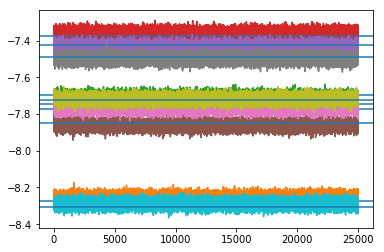

In [30]:
for i in range(10):
    mp.plot(test[3][0, i, n_samples/2:])
    mp.axhline(m_true[0, i])
    print np.mean(test[3][0, i, n_samples/2:]), np.std(test[3][0, i, n_samples/2:]), m_true[0, i]

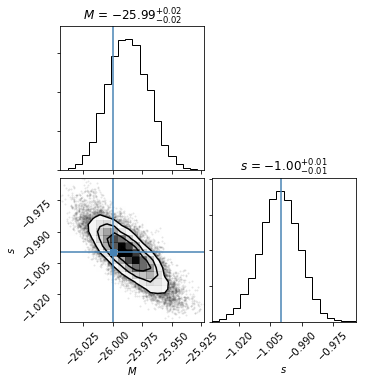

In [41]:
import corner
samples = np.stack((test[0], test[1]))
fig = corner.corner(samples[:, n_samples/2:].T, labels=[r"$M$", r"$s$"],
                    show_titles=True, truths=[abs_bar, s_bar])


In [68]:
def gls_fit(n_gal, n_star, mu_hat, mu_hat_sig, m_hat, m_sig_int, m_hat_sig, \
            lp_true, priors=None):

    # setup
    # n_obs is one anchor constraint and one magnitude per Cepheid.
    # n_par is one delta-mu per distance anchor, one mu per Cepheid. 
    # host and 2 CPL params. if priors are used, we add on n_gal + 2 
    # observations: one prior constraint on each host distance 
    # modulus and CPL parameter
    n_obs = n_gal * n_star + 1
    n_par = n_gal + 2
    if priors is not None:
        n_obs += n_gal + 2
    data = np.zeros(n_obs)
    design = np.zeros((n_obs, n_par))
    cov_inv = np.zeros((n_obs, n_obs))
    
    # anchor(s)
    data[0] = mu_hat
    design[0, 0] = 1.0
    cov_inv[0, 0] = 1.0 / mu_hat_sig ** 2

    # Cepheids
    k = 1
    for i in range(0, n_gal):
        for j in range(0, n_star):

            data[k] = m_hat[i, j]
            design[k, i] = 1.0
            design[k, n_gal] = 1.0
            design[k, n_gal + 1] = lp_true[i, j]
            cov_inv[k, k] = 1.0 / (m_hat_sig ** 2 + m_sig_int ** 2)
            k += 1
    
    # and, finally, priors if desired
    if priors is not None:
        abs_bar, abs_sig, s_bar, s_sig, mu_bar, mu_sig = priors
        for i in range(n_gal):
            data[k] = mu_bar
            design[k, i] = 1.0
            cov_inv[k, k] = 1.0 / mu_sig ** 2
            k += 1
        data[k] = abs_bar
        design[k, n_gal] = 1.0
        cov_inv[k, k] = 1.0 / abs_sig ** 2
        k += 1
        data[k] = s_bar
        design[k, n_gal + 1] = 1.0
        cov_inv[k, k] = 1.0 / s_sig ** 2
        k += 1
        
    # fit and return
    destci = np.dot(design.transpose(), cov_inv)
    pars_cov = np.linalg.inv(np.dot(destci, design))
    pars = np.dot(np.dot(pars_cov, destci), data)
    res = data - np.dot(design, pars)
    dof = n_obs - n_par
    chisq_dof = np.dot(res.transpose(), np.dot(cov_inv, res))
    return pars, pars_cov, chisq_dof

In [112]:
gls_pars, gls_pars_cov, gls_chisq = gls_fit(n_gal, n_star, mu_hat, mu_hat_sig, m_hat, \
                                            m_sig_int, m_hat_sig, lp_true, \
                                            priors=[abs_bar, abs_sig, s_bar, s_sig, mu_bar, mu_sig])

In [113]:
print gls_pars
print np.sqrt(np.diag(gls_pars_cov))

[ 19.6369342   42.92648902 -25.98561128  -1.0013665 ]
[0.00999993 0.01136469 0.01770187 0.00942306]


In [73]:
gls_pars, gls_pars_cov, gls_chisq = gls_fit(n_gal, n_star, mu_hat, mu_hat_sig, m_hat, \
                                            m_sig_int, m_hat_sig, lp_true)
print gls_pars
print np.sqrt(np.diag(gls_pars_cov))

[ 19.63694436  42.92651424 -25.98563146  -1.0013648 ]
[0.01       0.01136478 0.01770257 0.00942353]


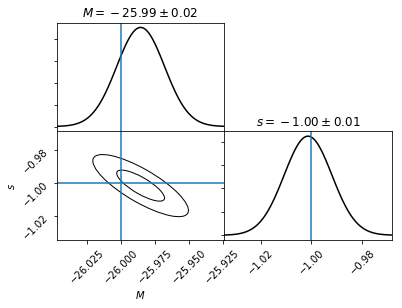

In [187]:
import scipy.stats as sps
def schmorner(par_mean, par_cov, par_true, par_label):
    
    # setup
    par_std = np.sqrt(np.diag(par_cov))
    x_min = par_mean[0] - 3.5 * par_std[0]
    x_max = par_mean[0] + 3.5 * par_std[0]
    y_min = par_mean[1] - 3.5 * par_std[1]
    y_max = par_mean[1] + 3.5 * par_std[1]
    fig, axes = mp.subplots(2, 2)
    
    # 1D marge
    x = np.linspace(x_min, x_max, 100)
    axes[0, 0].plot(x, sps.norm.pdf(x, par_mean[0], par_std[0]), 'k')
    axes[0, 0].axvline(par_true[0])
    axes[1, 0].axvline(par_true[0])
    axes[0, 0].set_xticklabels([])
    axes[0, 0].set_yticklabels([])
    axes[0, 0].set_xlim(x_min, x_max)
    axes[0, 0].set_title(par_label[0])
    axes[0, 0].set_title(par_label[0] + r'$=' + '{:6.2f}'.format(par_mean[0]) + \
                         r'\pm' + '{:4.2f}'.format(par_std[0]) + r'$')
    y = np.linspace(y_min, y_max, 100)
    axes[1, 1].plot(y, sps.norm.pdf(y, par_mean[1], par_std[1]), 'k')
    axes[1, 0].axhline(par_true[1])
    axes[1, 1].axvline(par_true[1])
    axes[1, 1].tick_params(labelleft=False)
    axes[1, 1].set_xlim(y_min, y_max)
    for tick in axes[1, 1].get_xticklabels():
        tick.set_rotation(45)
    axes[1, 1].set_title(par_label[1] + r'$=' + '{:5.2f}'.format(par_mean[1]) + \
                         r'\pm' + '{:4.2f}'.format(par_std[1]) + r'$')

    # 2D marge
    vals, vecs = np.linalg.eig(par_cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, 0]))
    w, h = 2 * np.sqrt(vals)
    ell = mpp.Ellipse(xy=par_mean, width=w, height=h,
                      angle=theta, color='k')
    ell.set_facecolor("none")
    axes[1, 0].add_artist(ell)
    ell = mpp.Ellipse(xy=par_mean, width=2*w, height=2*h,
                      angle=theta, color='k')
    ell.set_facecolor("none")
    axes[1, 0].add_artist(ell)
    axes[1, 0].set_xlim(x_min, x_max)
    axes[1, 0].set_ylim(y_min, y_max)
    for tick in axes[1, 0].get_xticklabels():
        tick.set_rotation(45)
    for tick in axes[1, 0].get_yticklabels():
        tick.set_rotation(45)
    axes[1, 0].set_xlabel(par_label[0])
    axes[1, 0].set_ylabel(par_label[1])
    fig.delaxes(axes[0, 1])
    fig.subplots_adjust(hspace=0, wspace=0)
    
test = schmorner(gls_pars[n_gal:], gls_pars_cov[n_gal:, n_gal:], \
                 [abs_bar, s_bar], [r'$M$', r'$s$'])
#import matplotlib.patches as mpp
#lazy = npr.multivariate_normal(gls_pars[n_gal:], gls_pars_cov[n_gal:, n_gal:], n_samples)
#fig = corner.corner(samples.T, labels=[r"$M$", r"$s$"],
#                    show_titles=True, truths=[abs_bar, s_bar])

In [108]:
import pystan as ps
import pickle

stan_code = """
data {
    int<lower=0> n_gal;
    int<lower=0> n_star;
    real mu_hat;
    real mu_hat_sig;
    real m_hat[n_gal, n_star];
    real m_hat_sig;
    real m_sig_int;
    real lp_true[n_gal, n_star];
    real abs_bar;
    real abs_sig;
    real s_bar;
    real s_sig;
    real mu_bar;
    real mu_sig;
}
parameters {
    real mu_true[n_gal];
    real m_true[n_gal, n_star];
    real abs_true;
    real s_true;
}
model {
    // priors
    abs_true ~ normal(abs_bar, abs_sig);
    s_true ~ normal(s_bar, s_sig);
    mu_true ~ normal(mu_bar, mu_sig);
    
    // whatevers
    for(i in 1: n_gal){
        for(j in 1: n_star){
            m_true[i, j] ~ normal(mu_true[i] + abs_true + s_true * lp_true[i, j], m_sig_int);
        }
    }
    
    // likelihoods
    mu_hat ~ normal(mu_true[1], mu_hat_sig);
    for(i in 1: n_gal){
        for(j in 1: n_star){
            m_hat[i, j] ~ normal(m_true[i, j], m_hat_sig);
        }
    }
}
"""
n_samples_stan = 5000
recompile = False
if recompile:
    stan_model = ps.StanModel(model_code=stan_code)
    with open('bhms_stan_model.pkl', 'wb') as f:
        pickle.dump(stan_model, f)
else:
    try:
        with open('bhms_stan_model.pkl', 'rb') as f:
            stan_model = pickle.load(f)
    except EnvironmentError:
        print 'ERROR: pickled Stan model (bhms_stan_model.pkl) not found. ' + \
              'Please set recompile = True'
        exit()
stan_data = {'n_gal': n_gal, 'n_star': n_star, 'mu_hat': mu_hat[0], 'mu_hat_sig': mu_hat_sig, \
             'm_hat': m_hat, 'm_hat_sig': m_hat_sig, 'm_sig_int': m_sig_int, 'lp_true': lp_true, \
             'abs_bar': abs_bar, 'abs_sig': abs_sig, 's_bar': s_bar, 's_sig': s_sig, \
             'mu_bar': mu_bar, 'mu_sig': mu_sig}
sm = ps.StanModel(model_code=stan_code)
fit = sm.sampling(data=stan_data, iter=n_samples_stan, chains=4)

In [110]:
samples = fit.extract(permuted=True)
print fit

Inference for Stan model: anon_model_ab41b39e55c2f57c74acf30e86ea4ea5.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_true[0]     19.64  1.2e-4 9.9e-3  19.62  19.63  19.64  19.64  19.66 6423.0    1.0
mu_true[1]     42.93  1.5e-4   0.01   42.9  42.92  42.93  42.93  42.95 6043.0    1.0
m_true[0,0]    -7.73  1.8e-4   0.02  -7.77  -7.75  -7.73  -7.72   -7.7  10000    1.0
m_true[1,0]    15.22  1.9e-4   0.02  15.19  15.21  15.22  15.23  15.26  10000    1.0
m_true[0,1]    -8.26  1.9e-4   0.02  -8.29  -8.27  -8.26  -8.24  -8.22  10000    1.0
m_true[1,1]    15.21  1.9e-4   0.02  15.17   15.2  15.21  15.22  15.24  10000    1.0
m_true[0,2]    -7.71  1.8e-4   0.02  -7.74  -7.72  -7.71   -7.7  -7.67  10000    1.0
m_true[1,2]    15.89  1.9e-4   0.02  15.85  15.88  15.89   15.9  15.93  10000    1.0
m_true[0,3]    -7.36  1.9e-4   0.02  -7.39  -

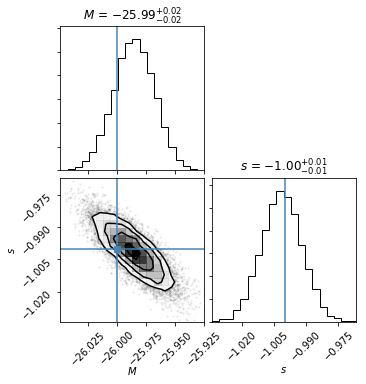

In [111]:
samples = np.stack((samples['abs_true'], samples['s_true']))
fig = corner.corner(samples.T, labels=[r"$M$", r"$s$"],
                    show_titles=True, truths=[abs_bar, s_bar])